#### What is Next Word Prediction?


Next word prediction using LSTM involves training a neural network to generate the most likely word that should follow a given sequence of words in a sentence, leveraging the ability of LSTMs to capture long-term dependencies in text.

- So, I will be working on text dataset which is a book written by **Plato - The Republic**. 
- [Dataset Link](https://www.kaggle.com/datasets/nischithajayaraj/republictxt)
- We will preprocess the data into a more reusable format and train our Deep Learning LSTM model. 
- This model is based on Neural Network architecture and provide high accuracy  on sequence based datasets by handling the drawbacks of simple RNN achitecture and adding long term dependancy to RNN. 
- LSTM has internal cell state helping the models to remember sequence of data input and changes that are helping.

In [1]:
# Import Dependancies

import numpy as np
import pandas as pd

import re
import os
import string
import random

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.notebook import tqdm

import pickle
import joblib

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read Dataset

try:
    with open("republic.txt", "r", encoding="utf8") as file:
        data = file.read()
        print("File content:")
        print(data[:1000])

except FileNotFoundError:
    print("The file 'republic.txt' was not found.")

File content:
The Project Gutenberg eBook of The Republic, by Plato

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.

Title: The Republic

Author: Plato

Translator: B. Jowett

Release Date: October, 1998 [eBook #1497]
[Most recently updated: September 11, 2021]

Language: English


Produced by: Sue Asscher and David Widger

*** START OF THE PROJECT GUTENBERG EBOOK THE REPUBLIC ***




THE REPUBLIC

By Plato

Translated by Benjamin Jowett

Note: See also “The Republic” by Plato, Jowett, eBook #150


Contents

 INTRODUCTION AND ANALYSIS.
 THE REPUBLIC.
 PERSONS OF THE DIALOGUE.
 BOOK I.
 BOOK II.
 B

In [3]:
# clean the text - remove html tags

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

# clean the text - remove urls

def _replace_urls(data):
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)
    return data

# clean the text - remove emails

def remove_email(data):
    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)
    return data

# clean the text - remove misc characters

def misc(data):
    # Remove new line characters - In regular expressions, \s+ is a pattern used to match one or more consecutive whitespace characters.
    data = re.sub('\s+', ' ', data)
    
    # Remove distracting single quotes
    data = re.sub("\'", "", data)
    data = re.sub("ww+", "", data)
    
    # Removing roman-case:
    MAYBE_ROMAN = re.compile(r'(\b[MDCLXVI]+\b)(\.)?', re.I)
    data = re.sub(MAYBE_ROMAN, "", data)
    
    return data

def tokenize_sentences(sentences):
   
    print("Starting Cleaning Process")
    
    tokenized_sentences = []
    
    for sentence in tqdm(sentences):
        
        # clean the sentence
        sentence = cleanhtml(sentence)
        
        sentence = _replace_urls(sentence)
        
        sentence = remove_email(sentence)
        
        sentence = re.sub(r'[^a-zA-Z]', ' ', sentence)
        
        sentence = sentence.lower()
        
        sentence = misc(sentence)
        
        tokenized_sentences.append(sentence)
    
    return tokenized_sentences

In [4]:
# remove short sentences - with words less than 5

def littleCleaning(sentences):
    print("Starting cleaning Process")
    ret_list = []
    for sentence in sentences:
      words = sentence.split(" ")
      if len(words) > 5:
        ret_list.append(sentence)
      else:
        continue
    return ret_list

In [5]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anant\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anant\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
path = 'republic.txt'
text = open(path).read().lower()
print('length of the corpus is: :', len(text))

length of the corpus is: : 566392


In [7]:
# Converting the data into lists.

data_list = text.split(".")

# Viewing first 20 sentences
data_list[:20]

['the project gutenberg ebook of the republic, by plato\n\nthis ebook is for the use of anyone anywhere in the united states and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever',
 ' you may copy it, give it away or re-use it under the terms\nof the project gutenberg license included with this ebook or online at\nwww',
 'gutenberg',
 'org',
 ' if you are not located in the united states, you\nwill have to check the laws of the country where you are located before\nusing this ebook',
 '\n\ntitle: the republic\n\nauthor: plato\n\ntranslator: b',
 ' jowett\n\nrelease date: october, 1998 [ebook #1497]\n[most recently updated: september 11, 2021]\n\nlanguage: english\n\n\nproduced by: sue asscher and david widger\n\n*** start of the project gutenberg ebook the republic ***\n\n\n\n\nthe republic\n\nby plato\n\ntranslated by benjamin jowett\n\nnote: see also “the republic” by plato, jowett, ebook #150\n\n\ncontents\n\n introduction and analysis',
 '\n the 

In [8]:
print("Total number of sentences:", len(data_list))

Total number of sentences: 3451


In [9]:
# creating a list of processed sentences
pro_sentences = []

In [10]:
# Normalization Pipeline

def normalization_pipeline(sentences):
    print("Starting Normalization Process")
    sentences = tokenize_sentences(sentences)
    sentences = littleCleaning(sentences)
    print("Normalization Process Finished")
    return sentences

pro_sentences = normalization_pipeline(data_list)
pro_sentences[0:10]

Starting Normalization Process
Starting Cleaning Process


  0%|          | 0/3451 [00:00<?, ?it/s]

Starting cleaning Process
Normalization Process Finished


['the project gutenberg ebook of the republic by plato this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever',
 ' you may copy it give it away or re use it under the terms of the project gutenberg license included with this ebook or online at ',
 ' if you are not located in the united states you will have to check the laws of the country where you are located before using this ebook',
 ' title the republic author plato translator b',
 ' jowett release date october ebook most recently updated september language english produced by sue asscher and david widger start of the project gutenberg ebook the republic the republic by plato translated by benjamin jowett note see also the republic by plato jowett ebook contents introduction and analysis',
 ' the republic of plato is the longest of his works with the exception of the laws and is certainly the greatest of them',
 ' there are nearer app

In [11]:
#!pip install ipywidgets --upgrade

In [12]:
#!jupyter nbextension enable --py widgetsnbextension

In [13]:
# How many sentences we have here?

print("Total number of sentences:", len(pro_sentences))

Total number of sentences: 3189


In [14]:
# first senstence

print("First sentence:\n", pro_sentences[0])

First sentence:
 the project gutenberg ebook of the republic by plato this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever


In [15]:
# first senstence - number of characters and number of words

print("First sentence:\n", pro_sentences[0])
print("Number of characters:", len(pro_sentences[0]))
print("Number of words:", len(pro_sentences[0].split()))

First sentence:
 the project gutenberg ebook of the republic by plato this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever
Number of characters: 206
Number of words: 38


In [16]:
# Viewing first 10 sentences

for i in range(10):
    print(f"{i+1} --> {pro_sentences[i]}")
    

1 --> the project gutenberg ebook of the republic by plato this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever
2 -->  you may copy it give it away or re use it under the terms of the project gutenberg license included with this ebook or online at 
3 -->  if you are not located in the united states you will have to check the laws of the country where you are located before using this ebook
4 -->  title the republic author plato translator b
5 -->  jowett release date october ebook most recently updated september language english produced by sue asscher and david widger start of the project gutenberg ebook the republic the republic by plato translated by benjamin jowett note see also the republic by plato jowett ebook contents introduction and analysis
6 -->  the republic of plato is the longest of his works with the exception of the laws and is certainly the greatest of them
7 -->  ther

In [17]:
# Structuring the text into a paragraph:

dataText = "".join(pro_sentences[:1500])

dataText[: 2000]

'the project gutenberg ebook of the republic by plato this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever you may copy it give it away or re use it under the terms of the project gutenberg license included with this ebook or online at  if you are not located in the united states you will have to check the laws of the country where you are located before using this ebook title the republic author plato translator b jowett release date october ebook most recently updated september language english produced by sue asscher and david widger start of the project gutenberg ebook the republic the republic by plato translated by benjamin jowett note see also the republic by plato jowett ebook contents introduction and analysis the republic of plato is the longest of his works with the exception of the laws and is certainly the greatest of them there are nearer approaches to modern metaphysics i

In [18]:
# Length of the text

len(dataText)

252159

In [19]:
# turn a doc into clean tokens
def clean_doc(doc):
    # replace '--' with a space ' '
    doc = doc.replace('--', ' ')
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # make lower case
    tokens = [word.lower() for word in tokens]
    return tokens

In [20]:
# clean document
tokens = clean_doc(dataText)

In [21]:
tokens

['the',
 'project',
 'gutenberg',
 'ebook',
 'of',
 'the',
 'republic',
 'by',
 'plato',
 'this',
 'ebook',
 'is',
 'for',
 'the',
 'use',
 'of',
 'anyone',
 'anywhere',
 'in',
 'the',
 'united',
 'states',
 'and',
 'most',
 'other',
 'parts',
 'of',
 'the',
 'world',
 'at',
 'no',
 'cost',
 'and',
 'with',
 'almost',
 'no',
 'restrictions',
 'whatsoever',
 'you',
 'may',
 'copy',
 'it',
 'give',
 'it',
 'away',
 'or',
 're',
 'use',
 'it',
 'under',
 'the',
 'terms',
 'of',
 'the',
 'project',
 'gutenberg',
 'license',
 'included',
 'with',
 'this',
 'ebook',
 'or',
 'online',
 'at',
 'if',
 'you',
 'are',
 'not',
 'located',
 'in',
 'the',
 'united',
 'states',
 'you',
 'will',
 'have',
 'to',
 'check',
 'the',
 'laws',
 'of',
 'the',
 'country',
 'where',
 'you',
 'are',
 'located',
 'before',
 'using',
 'this',
 'ebook',
 'title',
 'the',
 'republic',
 'author',
 'plato',
 'translator',
 'b',
 'jowett',
 'release',
 'date',
 'october',
 'ebook',
 'most',
 'recently',
 'updated',
 '

In [22]:
len(tokens)

46048

In [23]:
print(tokens[:250])

['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'republic', 'by', 'plato', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'in', 'the', 'united', 'states', 'and', 'most', 'other', 'parts', 'of', 'the', 'world', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', 'you', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 're', 'use', 'it', 'under', 'the', 'terms', 'of', 'the', 'project', 'gutenberg', 'license', 'included', 'with', 'this', 'ebook', 'or', 'online', 'at', 'if', 'you', 'are', 'not', 'located', 'in', 'the', 'united', 'states', 'you', 'will', 'have', 'to', 'check', 'the', 'laws', 'of', 'the', 'country', 'where', 'you', 'are', 'located', 'before', 'using', 'this', 'ebook', 'title', 'the', 'republic', 'author', 'plato', 'translator', 'b', 'jowett', 'release', 'date', 'october', 'ebook', 'most', 'recently', 'updated', 'september', 'language', 'english', 'produced', 'by', 'sue', 'asscher', 'and', 'david', 'widger', 'start', 

In [24]:
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

Total Tokens: 46048
Unique Tokens: 5209


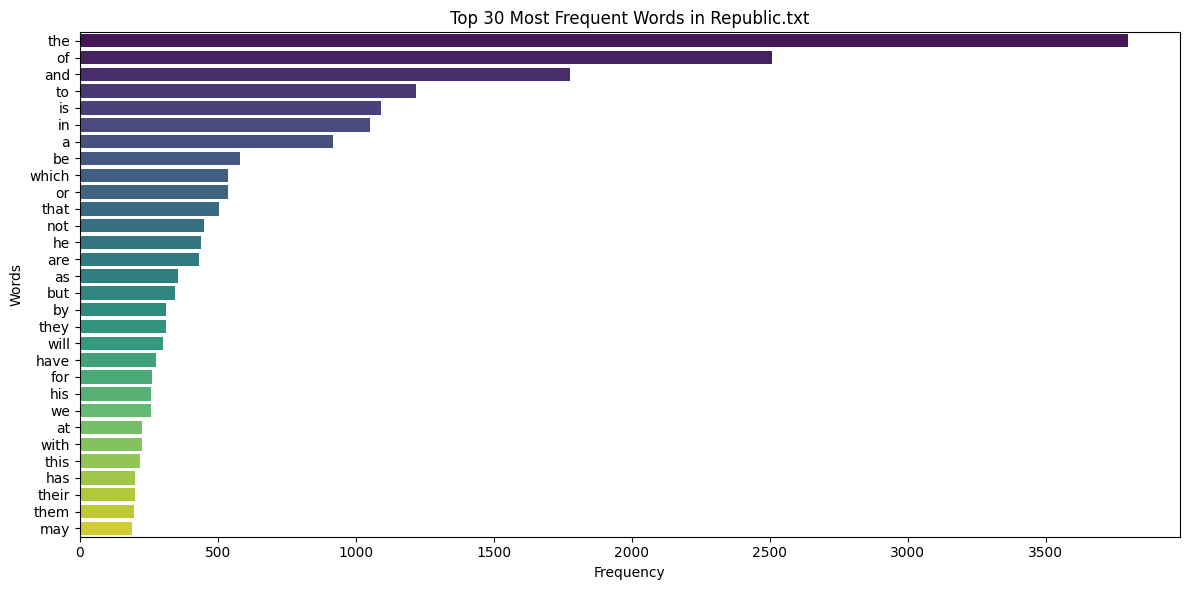

In [25]:
from collections import Counter

word_counts = Counter(tokens)
top_n = 30
common_words = word_counts.most_common(top_n)

# Convert to DataFrame for seaborn
df_common = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Plot histogram
plt.figure(figsize=(12, 6))
sns.barplot(data=df_common, x='Frequency', y='Word', palette='viridis')
plt.title('Top 30 Most Frequent Words in Republic.txt')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.tight_layout()
plt.show()

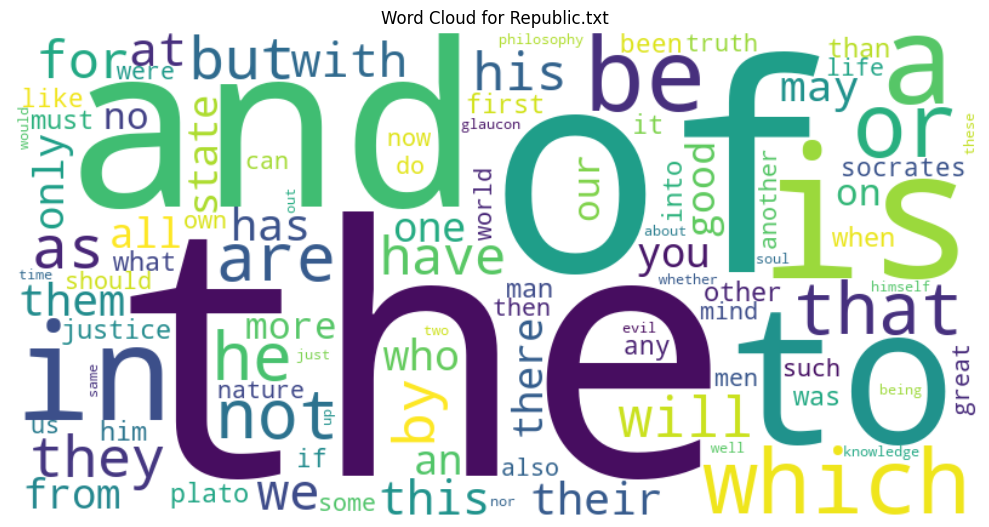

In [26]:
from wordcloud import WordCloud

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate_from_frequencies(dict(word_counts))

# Plot word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Republic.txt')
plt.tight_layout()
plt.savefig('word_cloud.png')
plt.show()

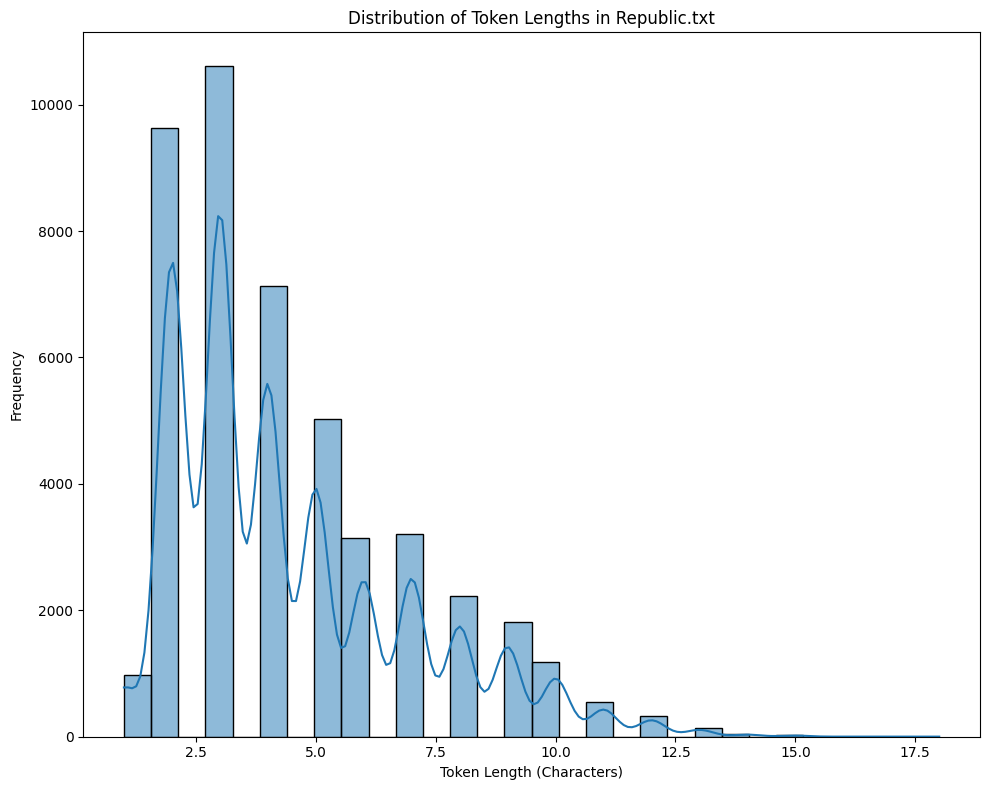

In [27]:
token_lengths = [len(token) for token in tokens]

# Plot histogram
plt.figure(figsize=(10, 8))
sns.histplot(token_lengths, bins=30, kde=True)
plt.title('Distribution of Token Lengths in Republic.txt')
plt.xlabel('Token Length (Characters)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('token_length_distribution.png')
plt.show()

In [28]:
# organize into sequences of tokens
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
    # select sequence of tokens
    seq = tokens[i-length:i]
    # convert into a line
    line = ' '.join(seq)
    # store
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))

Total Sequences: 45997


In [29]:
sequences[:5]

['the project gutenberg ebook of the republic by plato this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever you may copy it give it away or re use it under the',
 'project gutenberg ebook of the republic by plato this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever you may copy it give it away or re use it under the terms',
 'gutenberg ebook of the republic by plato this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever you may copy it give it away or re use it under the terms of',
 'ebook of the republic by plato this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever you may copy it give it a

In [30]:
# save sequences to file

# save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
    
out_filename = 'republic_sequences.txt'
save_doc(sequences, out_filename)

In [31]:
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [32]:
# load
in_filename = 'republic_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

In [33]:
lines[:10]

['the project gutenberg ebook of the republic by plato this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever you may copy it give it away or re use it under the',
 'project gutenberg ebook of the republic by plato this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever you may copy it give it away or re use it under the terms',
 'gutenberg ebook of the republic by plato this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever you may copy it give it away or re use it under the terms of',
 'ebook of the republic by plato this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever you may copy it give it a

In [34]:
print(len(lines))

45997


In [35]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

tokenizer = Tokenizer()

In [36]:
# https://medium.com/analytics-vidhya/understanding-nlp-keras-tokenizer-class-arguments-with-example-551c100f0cbd
tokenizer.fit_on_texts(lines)

In [37]:
#Get word index (dictionary mapping words to integers)

tokenizer.word_index

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'is': 5,
 'in': 6,
 'a': 7,
 'be': 8,
 'which': 9,
 'or': 10,
 'that': 11,
 'not': 12,
 'he': 13,
 'are': 14,
 'as': 15,
 'but': 16,
 'they': 17,
 'by': 18,
 'will': 19,
 'have': 20,
 'for': 21,
 'his': 22,
 'we': 23,
 'with': 24,
 'at': 25,
 'this': 26,
 'has': 27,
 'their': 28,
 'them': 29,
 'may': 30,
 'who': 31,
 'one': 32,
 'from': 33,
 'there': 34,
 'all': 35,
 'an': 36,
 'state': 37,
 'only': 38,
 'you': 39,
 'good': 40,
 'no': 41,
 'on': 42,
 'our': 43,
 'more': 44,
 'justice': 45,
 'into': 46,
 'plato': 47,
 'man': 48,
 'first': 49,
 'was': 50,
 'must': 51,
 'when': 52,
 'him': 53,
 'than': 54,
 'other': 55,
 'it': 56,
 'what': 57,
 'if': 58,
 'socrates': 59,
 'any': 60,
 'like': 61,
 'been': 62,
 'such': 63,
 'do': 64,
 'then': 65,
 'men': 66,
 'also': 67,
 'us': 68,
 'can': 69,
 'should': 70,
 'life': 71,
 'truth': 72,
 'world': 73,
 'were': 74,
 'some': 75,
 'mind': 76,
 'now': 77,
 'own': 78,
 'another': 79,
 'great': 80,
 'nature

In [38]:
# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(lines)

In [39]:
sequences[0]

[1,
 1779,
 1778,
 885,
 2,
 1,
 123,
 18,
 47,
 26,
 885,
 5,
 21,
 1,
 140,
 2,
 2640,
 1777,
 6,
 1,
 1339,
 159,
 3,
 190,
 55,
 286,
 2,
 1,
 73,
 25,
 41,
 5206,
 3,
 24,
 448,
 41,
 5205,
 5204,
 39,
 30,
 2638,
 56,
 262,
 56,
 347,
 10,
 1776,
 140,
 56,
 136,
 1]

In [40]:
len(sequences[0])

51

In [41]:
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1
vocab_size

5210

In [42]:
# separate into input and output
sequences = np.array(sequences)

In [43]:
sequences

array([[   1, 1779, 1778, ...,   56,  136,    1],
       [1779, 1778,  885, ...,  136,    1,  373],
       [1778,  885,    2, ...,    1,  373,    2],
       ...,
       [  13, 1172,    4, ...,  167, 1341,   33],
       [1172,    4,  233, ..., 1341,   33, 1072],
       [   4,  233,    1, ...,   33, 1072,    4]])

In [44]:
sequences.shape

(45997, 51)

In [45]:
X = sequences[:,:-1]

In [46]:
y = sequences[:,-1]

In [47]:
X

array([[   1, 1779, 1778, ...,  140,   56,  136],
       [1779, 1778,  885, ...,   56,  136,    1],
       [1778,  885,    2, ...,  136,    1,  373],
       ...,
       [  13, 1172,    4, ...,    1,  167, 1341],
       [1172,    4,  233, ...,  167, 1341,   33],
       [   4,  233,    1, ..., 1341,   33, 1072]])

In [48]:
y

array([   1,  373,    2, ...,   33, 1072,    4])

In [49]:
X.shape, y.shape

((45997, 50), (45997,))

In [50]:
y = to_categorical(y, num_classes=vocab_size)
y

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [51]:
y.shape

(45997, 5210)

In [52]:
seq_length = X.shape[1]
seq_length

50

In [53]:
vocab_size

5210

In [54]:
# LSTM define model
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(50, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
model.build(input_shape=(None, seq_length))
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 50)         │       260,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5210)           │       265,710 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 569,160 (2.17 MB)

 Trainable params: 569,160 (2.17 MB)

 Non-trainable params: 0 (0.00 B)

None


In [55]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
model.fit(X, y, batch_size=128, epochs=150, verbose=1)

Epoch 1/150
360/360 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.0787 - loss: 6.4961
Epoch 2/150
360/360 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.1076 - loss: 6.0412
Epoch 3/150
360/360 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.1219 - loss: 5.8678
Epoch 4/150
360/360 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.1288 - loss: 5.7212
Epoch 5/150
360/360 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.1345 - loss: 5.6241
Epoch 6/150
360/360 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.1402 - loss: 5.5468
Epoch 7/150
360/360 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.1464 - loss: 5.4797
Epoch 8/150
360/360 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.1510 - loss: 5.4178
Epoch 9/150
360/360 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.1545 - loss: 5.3603
Epoch 10/150
360/360 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.1586 - loss: 5.2986
Epoch 11/150
360/360 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.1628 - loss: 5.2402
Epoch 12/150
360/36

In [56]:
# save the model to file
model.save("model_next_word_predict.h5")
# save the tokenizer
pickle.dump(tokenizer, open('model_nwp_tokenizer.pkl', 'wb'))

In [57]:
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = []
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        token_list = tokenizer.texts_to_sequences([in_text])[0]
        # pre-pad sequences to a fixed length
        token_list = pad_sequences([token_list], maxlen=seq_length, padding='pre')
        # predict probabilities for each word
        predicted = np.argmax(model.predict(token_list), axis=-1)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

In [58]:
# load cleaned text sequences
in_filename = 'E:\\LiveDemoIoT\\republic_sequences.txt'

In [59]:
doc = load_doc(in_filename)

In [60]:
print(doc[0:100])

the project gutenberg ebook of the republic by plato this ebook is for the use of anyone anywhere in


In [61]:
lines = doc.split('\n')

In [62]:
lines

['the project gutenberg ebook of the republic by plato this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever you may copy it give it away or re use it under the',
 'project gutenberg ebook of the republic by plato this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever you may copy it give it away or re use it under the terms',
 'gutenberg ebook of the republic by plato this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever you may copy it give it away or re use it under the terms of',
 'ebook of the republic by plato this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever you may copy it give it a

In [63]:
lines[0].split()

['the',
 'project',
 'gutenberg',
 'ebook',
 'of',
 'the',
 'republic',
 'by',
 'plato',
 'this',
 'ebook',
 'is',
 'for',
 'the',
 'use',
 'of',
 'anyone',
 'anywhere',
 'in',
 'the',
 'united',
 'states',
 'and',
 'most',
 'other',
 'parts',
 'of',
 'the',
 'world',
 'at',
 'no',
 'cost',
 'and',
 'with',
 'almost',
 'no',
 'restrictions',
 'whatsoever',
 'you',
 'may',
 'copy',
 'it',
 'give',
 'it',
 'away',
 'or',
 're',
 'use',
 'it',
 'under',
 'the']

In [64]:
len(lines[0].split())

51

In [65]:
seq_length = len(lines[0].split()) - 1

print("Total lines: ",len(lines))
print("First line text: ",lines[0])
print("Length of seq: ",seq_length)

Total lines:  45997
First line text:  the project gutenberg ebook of the republic by plato this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever you may copy it give it away or re use it under the
Length of seq:  50


In [66]:
# load the model
model = keras.models.load_model('model_next_word_predict.h5')

In [67]:
# load the tokenizer
tokenizer = pickle.load(open('model_nwp_tokenizer.pkl', 'rb'))

In [68]:
import random
from random import randint

In [69]:
randint(0,len(lines))

22598

In [70]:
# select a seed text
seed_text = lines[randint(0,len(lines))]
print(seed_text + '\n')

mind of nations and sometimes they are too much for merely temporal interests to resist they are the watchwords which all men use in matters of public policy as well as in their private dealings the peace of europe may be said to depend upon them in the most commercial and



In [71]:
# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 12)
print(generated)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
utilitarian perfection of greece is proves that is the implement of the


In [72]:
seed_text = "Natural Language "

In [74]:
# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 1)
print(generated)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
or


In [75]:
# Evaluation
# It refers to the process of assessing the performance of a trained machine learning model 
# on a specific dataset.(Loss and Accuracy)

print("Evaluation")
print(model.evaluate(X, y))

Evaluation
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5641 - loss: 1.9191
[1.9190906286239624, 0.5641237497329712]
